In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import itertools

import matplotlib.pyplot as plt
import seaborn as sns

from os import listdir
from os.path import isfile, join

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import balanced_accuracy_score
from sklearn.preprocessing import LabelEncoder


import warnings
warnings.filterwarnings("ignore")

Code inspired by:
**Stübinger, Johannes and Julian Knoll. “Beat the Bookmaker - Winning Football Bets with Machine Learning** (Best Application Paper).” SGAI Conf. (2018).

# Import data

Source: https://www.football-data.co.uk/

In [2]:
# merge all csv files into one pandas dataframe:
onlyfiles = [f for f in listdir('premier') if isfile(join('premier', f))]

for i in onlyfiles:
    if i==onlyfiles[0]:
        data=pd.read_csv('premier/'+i,parse_dates=True,index_col='Date',dayfirst=True)
    else:
        data=pd.concat([pd.read_csv('premier/'+i,parse_dates=True,index_col='Date',dayfirst=True),data],axis=0)

# sort dataframe
data=data.sort_index().iloc[:-1]

# Data cleaning

In [3]:
data_=data.iloc[:,2:data.columns.to_list().index('B365H')].drop(['HTHG','HTAG','HTR'],axis=1)
data_['y']=data_['FTAG']-data['FTHG']
data_=data_.drop(['FTHG','FTAG'],axis=1)
data_.dropna(inplace=True)

In [4]:
# convert categorical variables into numbers
l=LabelEncoder()
l.fit(np.union1d(data_.iloc[:,0].values,data_.iloc[:,1].values))
data_.iloc[:,0]=l.transform(data_.iloc[:,0].values)
data_.iloc[:,1]=l.transform(data_.iloc[:,1].values)

ll=LabelEncoder()
ll.fit(data_.iloc[:,2].values)
data_.iloc[:,2]=ll.transform(data_.iloc[:,2].values)
data_

,HomeTeam,AwayTeam,FTR,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,y
Date,,,,,,,,,,,,,,,,
2007-08-10,126,115,1,16.0,10.0,7.0,4.0,19.0,23.0,9.0,0.0,4.0,3.0,0.0,0.0,0.0
2007-08-11,10,61,2,27.0,6.0,13.0,0.0,14.0,13.0,4.0,1.0,0.0,3.0,0.0,0.0,-3.0
2007-08-11,17,140,1,17.0,20.0,4.0,9.0,15.0,17.0,7.0,6.0,1.0,2.0,0.0,0.0,0.0
2007-08-11,43,63,2,19.0,10.0,5.0,3.0,13.0,13.0,6.0,5.0,2.0,1.0,0.0,0.0,-1.0
2007-08-11,60,59,0,10.0,14.0,2.0,8.0,20.0,18.0,6.0,4.0,3.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-17,145,88,0,6.0,16.0,1.0,7.0,7.0,9.0,5.0,7.0,2.0,1.0,1.0,0.0,3.0
2022-09-17,93,20,1,20.0,10.0,7.0,3.0,10.0,11.0,8.0,1.0,2.0,2.0,0.0,0.0,0.0
2022-09-17,131,79,2,16.0,19.0,11.0,7.0,9.0,9.0,6.0,1.0,1.0,2.0,0.0,0.0,-4.0


# Model traning

In [5]:
# define a percentage split between train and test
percentage=0.15

df_train=data_.iloc[:int(len(data_)*percentage)]

# input hyperparameters for model fitting:
parameters={'random_state': [100],'max_depth': [4,8,10,12],'n_estimators': [20,40]}
parameters_=list((dict(zip(parameters, x)) for x in itertools.product(*parameters.values())))

In [6]:
d=np.array(data_) # transorm the dataset into numpy matrix 
roll=100 # define a rolling window for model fitting

In [7]:
# train RF and find the best hyperparameter:
accuracy=[]
for param in parameters_:
    pr=[]
    model=RandomForestClassifier(**param)
    for i in tqdm(range(roll,len(df_train))):
        try:
            X_test=np.round(np.median(d[np.where(np.logical_and(d[:i,1]==d[i,1],d[:i,0]==d[i,0]))][-3:],axis=0))[:-1].reshape(1, -1)
        
            model.fit(d[i-roll:i,:-1],d[i-roll:i,-1])    
            pr.append(np.array([d[i,-1],model.predict(X_test)[0]]))

        except:
            pr.append(np.array([d[i,-1],float('Nan')]))
        
    results=pd.DataFrame(pr,columns=['Actual','Predicted'])
        
    accuracy.append(balanced_accuracy_score(results.dropna()['Actual'],results.dropna()['Predicted']))
    print(accuracy[-1],param)

best_param = parameters_[np.argmax(accuracy)]
best_param




100%|██████████| 3049/3049 [01:27<00:00, 34.92it/s]


0.089427238880926 {'random_state': 100, 'max_depth': 4, 'n_estimators': 20}


100%|██████████| 3049/3049 [02:32<00:00, 19.96it/s]


0.08907483433331322 {'random_state': 100, 'max_depth': 4, 'n_estimators': 40}


100%|██████████| 3049/3049 [00:39<00:00, 77.71it/s]


0.09061612915346963 {'random_state': 100, 'max_depth': 8, 'n_estimators': 20}


100%|██████████| 3049/3049 [01:13<00:00, 41.33it/s]


0.09677554965449649 {'random_state': 100, 'max_depth': 8, 'n_estimators': 40}


100%|██████████| 3049/3049 [00:37<00:00, 80.28it/s]


0.09079908308287721 {'random_state': 100, 'max_depth': 10, 'n_estimators': 20}


100%|██████████| 3049/3049 [01:13<00:00, 41.23it/s]


0.0951668871973804 {'random_state': 100, 'max_depth': 10, 'n_estimators': 40}


100%|██████████| 3049/3049 [00:42<00:00, 72.44it/s]


0.09224591663016006 {'random_state': 100, 'max_depth': 12, 'n_estimators': 20}


100%|██████████| 3049/3049 [01:12<00:00, 42.07it/s]

0.09764736813271888 {'random_state': 100, 'max_depth': 12, 'n_estimators': 40}


{'random_state': 100, 'max_depth': 12, 'n_estimators': 40}

# Model evaluation

In [8]:
# evaluate model performance with test data
pr=[]

for i in tqdm(range(len(df_train),len(data_))):
    try:
        X_test=np.round(np.median(d[np.where(np.logical_and(d[:i,1]==d[i,1],d[:i,0]==d[i,0]))][-3:],axis=0))[:-1].reshape(1, -1)
        model=RandomForestClassifier(**best_param)
        model.fit(d[i-roll:i,:-1],d[i-roll:i,-1])
        
        pr.append(np.array([d[i,-1],model.predict(X_test)[0]]))

    except:
        pr.append(np.array([d[i,-1],float('Nan')]))
 
results=pd.DataFrame(pr,columns=['Actual','Predicted'])

100%|██████████| 17846/17846 [07:11<00:00, 41.39it/s]


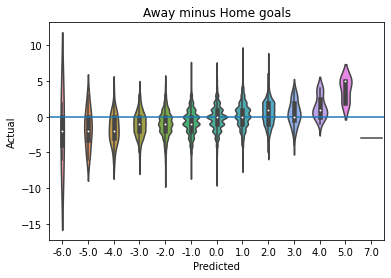

In [9]:
# display a violinplot to see the accuracy of predictions:

sns.violinplot(data=results,x='Predicted',y='Actual')
plt.axhline(0)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Away minus Home goals')
plt.show()

In [10]:
dd=data[['B365H','B365A']].iloc[len(df_train):-1].dropna()
rr=results.reset_index(drop=True).join(dd.reset_index(drop=True))


In [27]:
# Print some stats
print('Mean <-2 odd: ',rr[rr['Predicted']<-2]['B365H'].mean())
print('Mean <-2 implied probability: ',1/rr[rr['Predicted']<-2]['B365H'].mean())
print('TP/(TP+FP): ',rr[np.logical_and(rr['Predicted']<-2,rr['Actual']<0)].shape[0]/rr[rr['Predicted']<-2].shape[0])
print('--------')

print('Mean >2 odd: ',rr[rr['Predicted']>2]['B365A'].mean())
print('Mean >2 implied probability: ',1/(rr[rr['Predicted']>2]['B365A'].mean()))
print('TP/(TP+FP): ',rr[np.logical_and(rr['Predicted']>2,rr['Actual']>0)].shape[0]/rr[rr['Predicted']>2].shape[0])


Mean <-2 odd:  2.7515533980582494
Mean <-2 implied probability:  0.3634310715923931
TP/(TP+FP):  0.627831715210356
--------
Mean >2 odd:  4.588035714285714
Mean >2 implied probability:  0.21795819873117195
TP/(TP+FP):  0.5357142857142857


# Strategy backtest

* When predicted >=2 and odd for Away win >1/0.53 --> Bet on away team
* When predicted <=-2 and odd for Home win >1/0.6 --> Bet on home team

In [29]:
1/0.62

1.6129032258064517

In [31]:
# backtest the strategy
ptf=pd.DataFrame(100,columns=['Wealth'],index=rr.index)
betted=pd.DataFrame(0,columns=['Wealth'],index=rr.index)
bet=10
c=0
for a,b in rr.iterrows():

    if (b['Predicted']>2)and(b['B365A']>1/0.53):
        betted.iloc[a]=betted.iloc[a-1]+bet
        c+=1
        if b['Predicted']>0:
            ptf.iloc[a]=ptf.iloc[a-1]+b['B365A']*bet
            
        else:
            ptf.iloc[a]=ptf.iloc[a-1]-bet
    if b['Predicted']<-2 and (b['B365H']>1/0.62):
        betted.iloc[a]=betted.iloc[a-1]+bet
        c+=1
        if b['Actual']<0:
            ptf.iloc[a]=ptf.iloc[a-1]+b['B365H']*bet
            
        else:
            ptf.iloc[a]=ptf.iloc[a-1]-bet
    else:
        betted.iloc[a]=betted.iloc[a-1]
        ptf.iloc[a]=ptf.iloc[a-1]


In [32]:
print('Number of bets: ', c)

Number of bets:  619


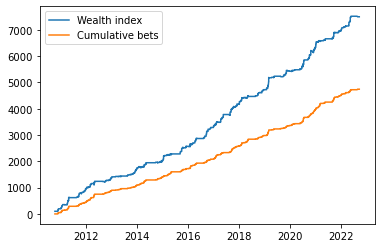

In [33]:
ptf.index=data_.iloc[len(df_train):].index
betted.index=data_.iloc[len(df_train):].index

plt.plot(ptf,label='Wealth index')
plt.plot(betted,label='Cumulative bets')
plt.legend()
plt.show()

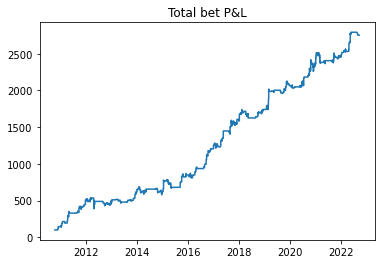

In [34]:
plt.plot(ptf-betted)
plt.title('Total bet P&L')
plt.show()

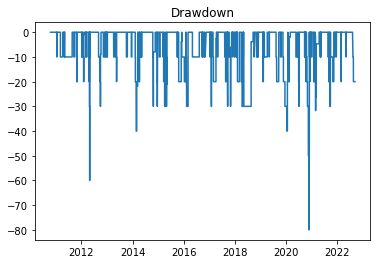

In [35]:
plt.plot(ptf-ptf.cummax())
plt.title('Drawdown')
plt.show()